<center><b><h1>Formative Assessment (Sports Prediction)</h1></b></center>
<center><h3>Machine Learning</h3></center>



## Importing required libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

## Setup Kaggle API

In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
kaggle_username = "oluwarotimiadesina"
kaggle_key = "c6242324dc4a957939185473c0631e48"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

## Download and explore dataset

In [4]:
# Download the dataset, it will be in a .zip file.
!kaggle datasets download -d karangadiya/fifa19

  0% 0.00/2.18M [00:00<?, ?B/s]
100% 2.18M/2.18M [00:00<00:00, 71.6MB/s]


In [5]:
# Unzip the downloaded file
!unzip -o fifa19.zip

Archive:  fifa19.zip
  inflating: data.csv                


## Data Ingestion

In [6]:
dataframe = pd.read_csv("data.csv")
dataframe.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## Exploratory Data analysis

In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

Text(0.5, 1.0, 'Age & Overall rating Distribution')

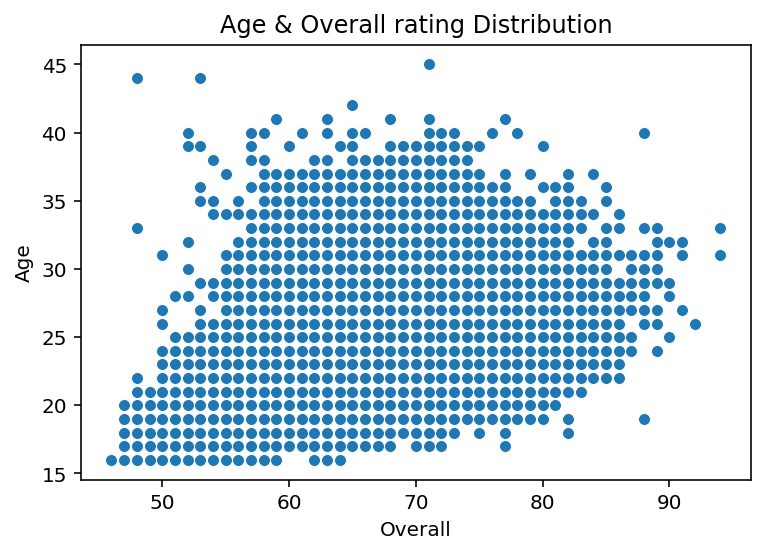

In [8]:
sns.scatterplot(x="Overall", y="Age", data=dataframe).set_title("Age & Overall rating Distribution")

Text(0.5, 0.98, 'Age vs Overall rating')

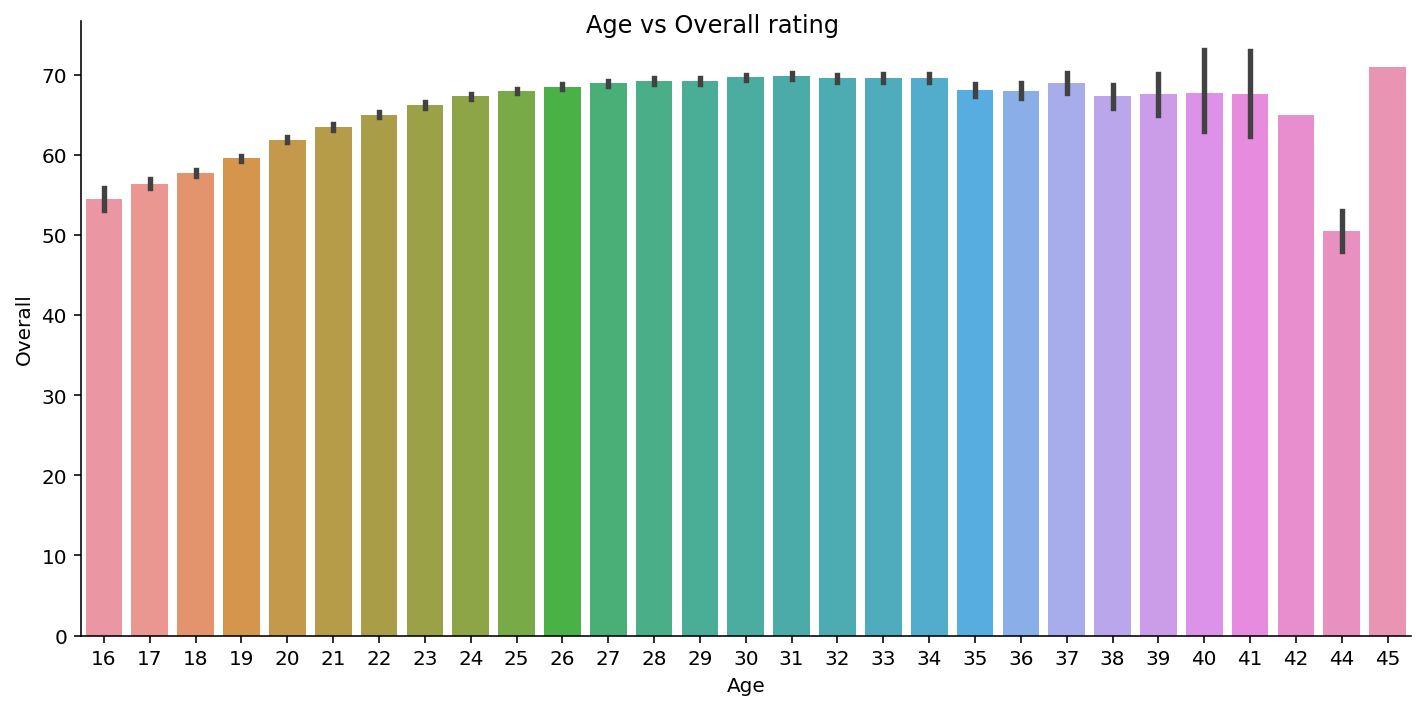

In [9]:
ax = sns.catplot(x="Age", y="Overall", kind="bar", data=dataframe, height=5, aspect=2)
ax.fig.suptitle("Age vs Overall rating")

Visualization inspiration: https://www.kaggle.com/oguzbozkurtmsc/fifa-19-data-visualization

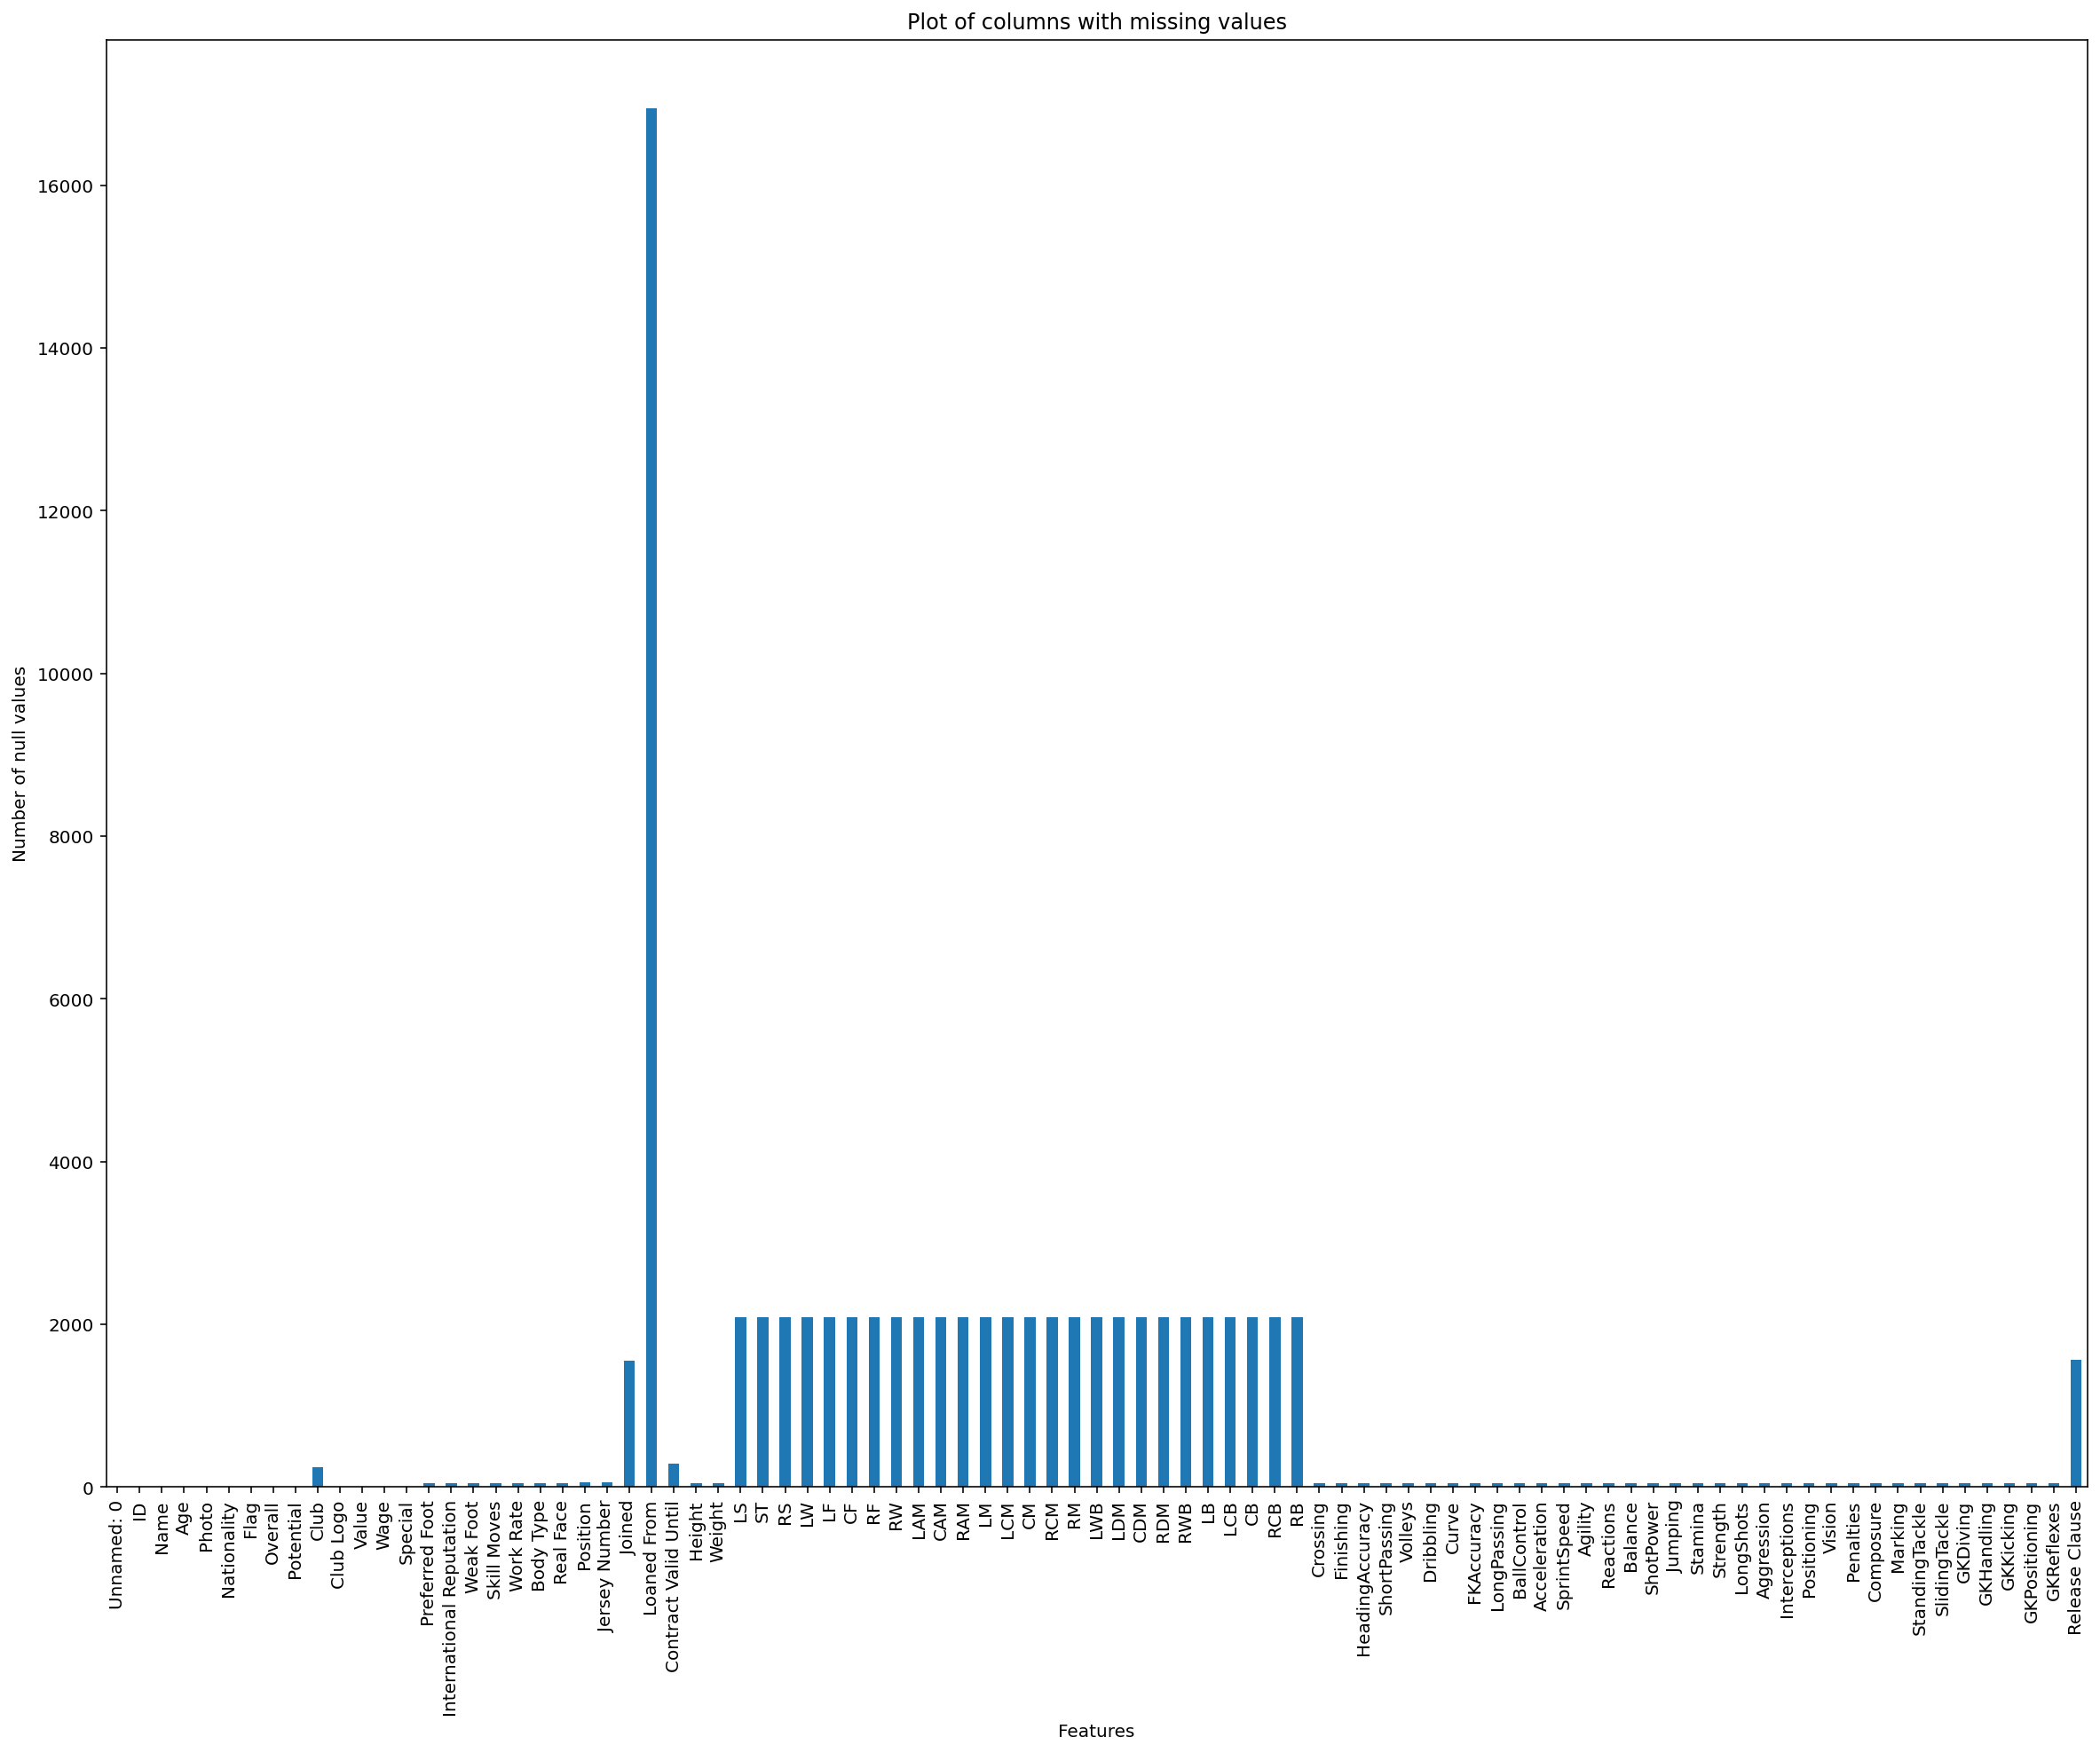

In [10]:
# Visialize the null values in the dataset
dataframe.isnull().sum(axis = 0).plot(
    kind="bar", 
    figsize=(20, 15), 
    title="Plot of columns with missing values", 
    xlabel = "Features", 
    ylabel = "Number of null values"
)

In [11]:
dataframe.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [12]:
# List of columns that do not add any useful information for training. 
columns_to_drop = [
    "Unnamed: 0", 
    "ID", 
    "Name", 
    "Photo", 
    "Flag", 
    "Club Logo", 
    "Loaned From", 
    "Real Face", 
    "Jersey Number", 
    "Joined", 
    "Nationality",
    "Club",
    "Potential"
]

for column_name in columns_to_drop:
    dataframe.drop(column_name, axis='columns', inplace=True)

In [13]:
# Remove the rows with null values. This is the best option since only a few are null and it is better to train
# with the existing data than to interpolate the missing values for accuracy. 
dataframe = dataframe.dropna(how='any')
dataframe.head()

,Age,Overall,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,94,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,RF,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,94,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,ST,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,92,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,LW,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
4,27,91,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,RCM,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
5,27,91,€93M,€340K,2142,Right,4.0,4.0,4.0,High/ Medium,Normal,LF,2020,5'8,163lbs,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,82+3,82+3,82+3,89+3,66+3,63+3,63+3,63+3,66+3,60+3,49+3,49+3,49+3,60+3,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,€172.1M


## Data Preparation

In [14]:
# Look at the datatypes present in the dataframe
pd.options.display.max_rows = 100
dataframe.dtypes

Age                           int64
Overall                       int64
Value                        object
Wage                         object
Special                       int64
Preferred Foot               object
International Reputation    float64
Weak Foot                   float64
Skill Moves                 float64
Work Rate                    object
Body Type                    object
Position                     object
Contract Valid Until         object
Height                       object
Weight                       object
LS                           object
ST                           object
RS                           object
LW                           object
LF                           object
CF                           object
RF                           object
RW                           object
LAM                          object
CAM                          object
RAM                          object
LM                           object
LCM                         

In [15]:
# Convert currency values like '€77M' --> 77 for model use.
def strip_currency_string(string):
    return float(string[1:len(string)-1])

features_to_strip = ["Value", "Wage", "Release Clause"]
for feature in features_to_strip:
    dataframe[feature] = dataframe[feature].apply(strip_currency_string)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [16]:
# Convert height from feet i.e '5'1' to 61 (inches).
def feet_to_inches(string):
    height = string.split("'")
    feet = int(height[0])
    inches = int(height[1])
    return feet*12 + inches

features = ["Height"]
for feature in features:
    dataframe[feature] = dataframe[feature].apply(feet_to_inches)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [17]:
# Convert weight string to integer value. i.e 50lbs to just 50
def get_weight(string):
    return int(string[:-3])
features = ["Weight"]
for feature in features:
    dataframe[feature] = dataframe[feature].apply(get_weight)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
# Convert position rating to an actual integer value i.e "88+2" --> 90. 
def get_position_rating(string):
    rank = string.split("+")
    return int(rank[0]) + int(rank[1])

position_name = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

for position in position_name:
    dataframe[position] = dataframe[position].apply(get_position_rating)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [19]:
# Convert strings to integers. 
features = ["Contract Valid Until"]
for feature in features:
    dataframe[feature] = dataframe[feature].apply(lambda x: int(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
# One hot encoding for categorical data
encoding_list = ["Preferred Foot", "Body Type", "Position"]

for val in encoding_list:
    dataframe[val] = pd.Categorical(dataframe[val])
    dummies = pd.get_dummies(dataframe[val], prefix = val+"_")
    dataframe=pd.concat([dataframe, dummies], axis=1)
    dataframe.drop(val, axis='columns', inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [21]:
# Ordered Data Encoding
encoder = OrdinalEncoder()
scale_mapper = {
    'Low/ Low':1, 
    'Low/ Medium':2, 
    'Low/ High':3, 
    'Medium/ Low':4, 
    'Medium/ Medium': 5, 
    'Medium/ High': 6,
    'High/ Low': 7,
    'High/ Medium': 8, 
    'High/ High': 9
}
dataframe['Work Rate'] = dataframe['Work Rate'].replace(scale_mapper)

## Spliting Data

In [22]:
# train: 0.8 | test: 0.2
df_train, df_test = train_test_split(dataframe, test_size=0.2, random_state=0)

# train: 0.6 | validation: 0.2
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=0)

# Final dataset sizes: train: 0.6, validation: 0.2, text: 0.2,

In [23]:
print("Train Data size: ", df_train.shape)
print("Test Data size: ", df_test.shape)
print("Validation Data size: ", df_val.shape)

Train Data size:  (8845, 110)
Test Data size:  (2949, 110)
Validation Data size:  (2949, 110)


## Define model evaluation metric

The following metrics will be used for the evaluation of the model's performance;
- **r2_score:** Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.

- **Root mean squared Error:** Root of mean squared error

- **Mean squared Error:** A non-negative floating point value (the best value is 0.0

- **Mean Absolute error:** MAE output is non-negative floating point. The best value is 0.0.

- **Pearson’s Correlation:** The Pearson correlation coefficient (named for Karl Pearson) can be used to summarize the strength of the linear relationship between two data samples.

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats.stats import pearsonr
from pprint import pprint


# All the metrics that will be evaluated for each model.
def eval_model(y_actual, y_predicted):
    r2 = r2_score(y_actual, y_predicted)
    rmse = mean_squared_error(y_actual, y_predicted, squared=False)
    mse = mean_squared_error(y_actual, y_predicted)
    mae = MAE(y_actual, y_predicted)
    pr, _ = pearsonr(y_actual, y_predicted)
    model_performance_dict = {
        "r2": r2,
        "root_mean_squared_error": rmse,
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
        "pearsonr": pr,
    }
    return model_performance_dict


## Training Baseline Models

### Linear Regressor

In [25]:
from sklearn.linear_model import LinearRegression

In [27]:
linear_regression_model = LinearRegression().fit(
    df_train.loc[:, df_train.columns != "Overall"], df_train["Overall"]
)

In [28]:
print("r2_score (Test data):", linear_regression_model.score(df_test.loc[:, df_test.columns != "Overall"], df_test["Overall"]))
print("r2_score (Validation Data):", linear_regression_model.score(df_val.loc[:, df_val.columns != "Overall"], df_val["Overall"]))

r2_score (Test data): 0.915350254770549
r2_score (Validation Data): 0.9188238224799498


In [35]:
linear_preds_test = linear_regression_model.predict(df_test.loc[:, df_test.columns != "Overall"])
print("linear preds test model eval: ")
pprint(eval_model(df_test["Overall"], linear_preds_test))

linear preds test model eval: 
{'mean_absolute_error': 1.5753623905781675,
 'mean_squared_error': 4.033299598875873,
 'pearsonr': 0.9567854644536921,
 'r2': 0.915350254770549,
 'root_mean_squared_error': 2.008307645475631}


In [37]:
linear_preds_val = linear_regression_model.predict(df_val.loc[:, df_val.columns != "Overall"])
print("linear preds val model eval: ")
pprint(eval_model(df_val["Overall"], linear_preds_val))

linear preds val model eval: 
{'mean_absolute_error': 1.54756285458156,
 'mean_squared_error': 3.865411485770012,
 'pearsonr': 0.9586276155407544,
 'r2': 0.9188238224799498,
 'root_mean_squared_error': 1.9660649749614105}


### Random Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
regressor_model = RandomForestRegressor().fit(
    df_train.loc[:, df_train.columns != "Overall"], df_train["Overall"])

In [41]:
print("r2_score (Test data):", regressor_model.score(df_test.loc[:, df_test.columns != "Overall"], df_test["Overall"]))
print("r2_score (Validation data):", regressor_model.score(df_val.loc[:, df_val.columns != "Overall"], df_val["Overall"]))

r2_score (Test data): 0.9916910914667453
r2_score (Validation data): 0.9929123120168496


In [42]:
rf_preds_test = regressor_model.predict(df_test.loc[:, df_test.columns != "Overall"])
print("Random forest preds test model eval: ")
pprint(eval_model(df_test["Overall"], rf_preds_test))

Random forest preds test model eval: 
{'mean_absolute_error': 0.372923024754154,
 'mean_squared_error': 0.3958938962360123,
 'pearsonr': 0.9958470117905529,
 'r2': 0.9916910914667452,
 'root_mean_squared_error': 0.6292009982795739}


In [43]:
rf_preds_val = regressor_model.predict(df_val.loc[:, df_val.columns != "Overall"])
print("Random forest preds val model eval: ")
pprint(eval_model(df_val["Overall"], rf_preds_val))

Random forest preds val model eval: 
{'mean_absolute_error': 0.3723974228552051,
 'mean_squared_error': 0.33749840623940297,
 'pearsonr': 0.9964624680138523,
 'r2': 0.9929123120168496,
 'root_mean_squared_error': 0.580946130238771}


### XGBoost

In [44]:
from sklearn.metrics import r2_score, accuracy_score
import xgboost as xgb

In [45]:
dtrain = xgb.DMatrix(
    df_train.loc[:, df_train.columns != "Overall"], label=df_train["Overall"]
)
dtest = xgb.DMatrix(
    df_test.loc[:, df_test.columns != "Overall"], label=df_test["Overall"]
)
dval = xgb.DMatrix(
    df_val.loc[:, df_val.columns != "Overall"], label=df_val["Overall"]
)

In [46]:
param = {
    "objective": "reg:squarederror",
}
num_round = 100
xgb_model = xgb.train(param, dtrain, num_round)

In [47]:
xgb_preds_test = xgb_model.predict(dtest)
print("XGB preds test model eval: ")
pprint(eval_model(df_test["Overall"], xgb_preds_test))

XGB preds test model eval: 
{'mean_absolute_error': 0.5043493822575748,
 'mean_squared_error': 0.543240297663864,
 'pearsonr': 0.9942836899022328,
 'r2': 0.9885986270872529,
 'root_mean_squared_error': 0.737048368605388}


In [48]:
xgb_preds_val = xgb_model.predict(dval)
print("XGBpreds val model eval: ")
pprint(eval_model(df_val["Overall"], xgb_preds_val))

XGBpreds val model eval: 
{'mean_absolute_error': 0.4820603751942197,
 'mean_squared_error': 0.4641023793131903,
 'pearsonr': 0.9951281916913138,
 'r2': 0.9902535455101489,
 'root_mean_squared_error': 0.6812505994956557}


## Feature Importance

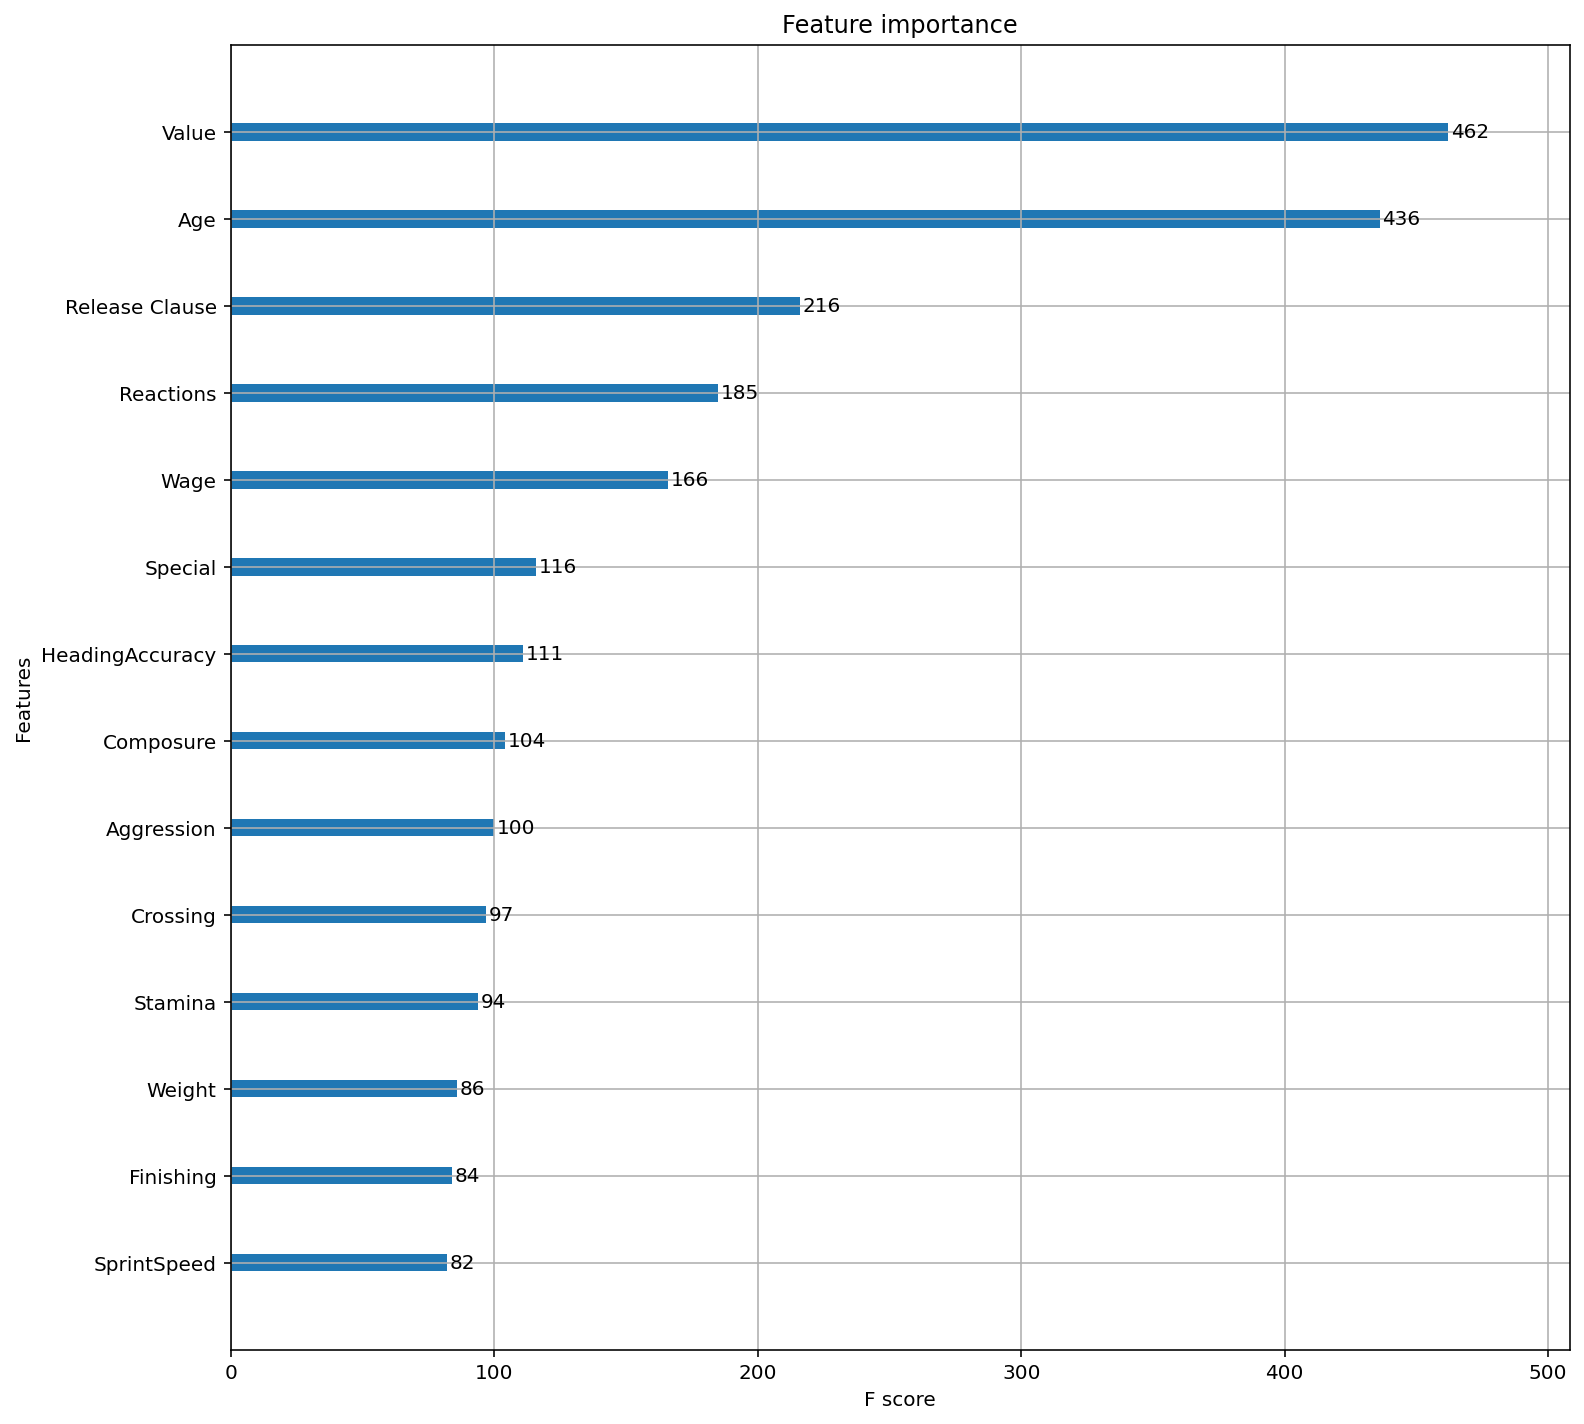

In [51]:
# Plot the most inportant features.
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(xgb_model, max_num_features=14, ax=ax)

In [52]:
# List of the most important features
feature_set = set([
                "Value", "Age", "Release Clause", "Reactions", "Wage", "Special", 
                "HeadingAccuracy", "Composure", "Aggression", "Crossing", "Stamina",
                "Weight", "Finishing", "SprintSpeed", "Overall"
                ])

# Training new model with only the selected features

In [53]:
for column_name in df_train.columns:
    if column_name not in feature_set:
        df_train.drop(column_name, axis='columns', inplace=True)
        df_test.drop(column_name, axis='columns', inplace=True)
        df_val.drop(column_name, axis='columns', inplace=True)

df_train.info()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8845 entries, 6478 to 8617
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              8845 non-null   int64  
 1   Overall          8845 non-null   int64  
 2   Value            8845 non-null   float64
 3   Wage             8845 non-null   float64
 4   Special          8845 non-null   int64  
 5   Weight           8845 non-null   int64  
 6   Crossing         8845 non-null   float64
 7   Finishing        8845 non-null   float64
 8   HeadingAccuracy  8845 non-null   float64
 9   SprintSpeed      8845 non-null   float64
 10  Reactions        8845 non-null   float64
 11  Stamina          8845 non-null   float64
 12  Aggression       8845 non-null   float64
 13  Composure        8845 non-null   float64
 14  Release Clause   8845 non-null   float64
dtypes: float64(11), int64(4)
memory usage: 1.1 MB


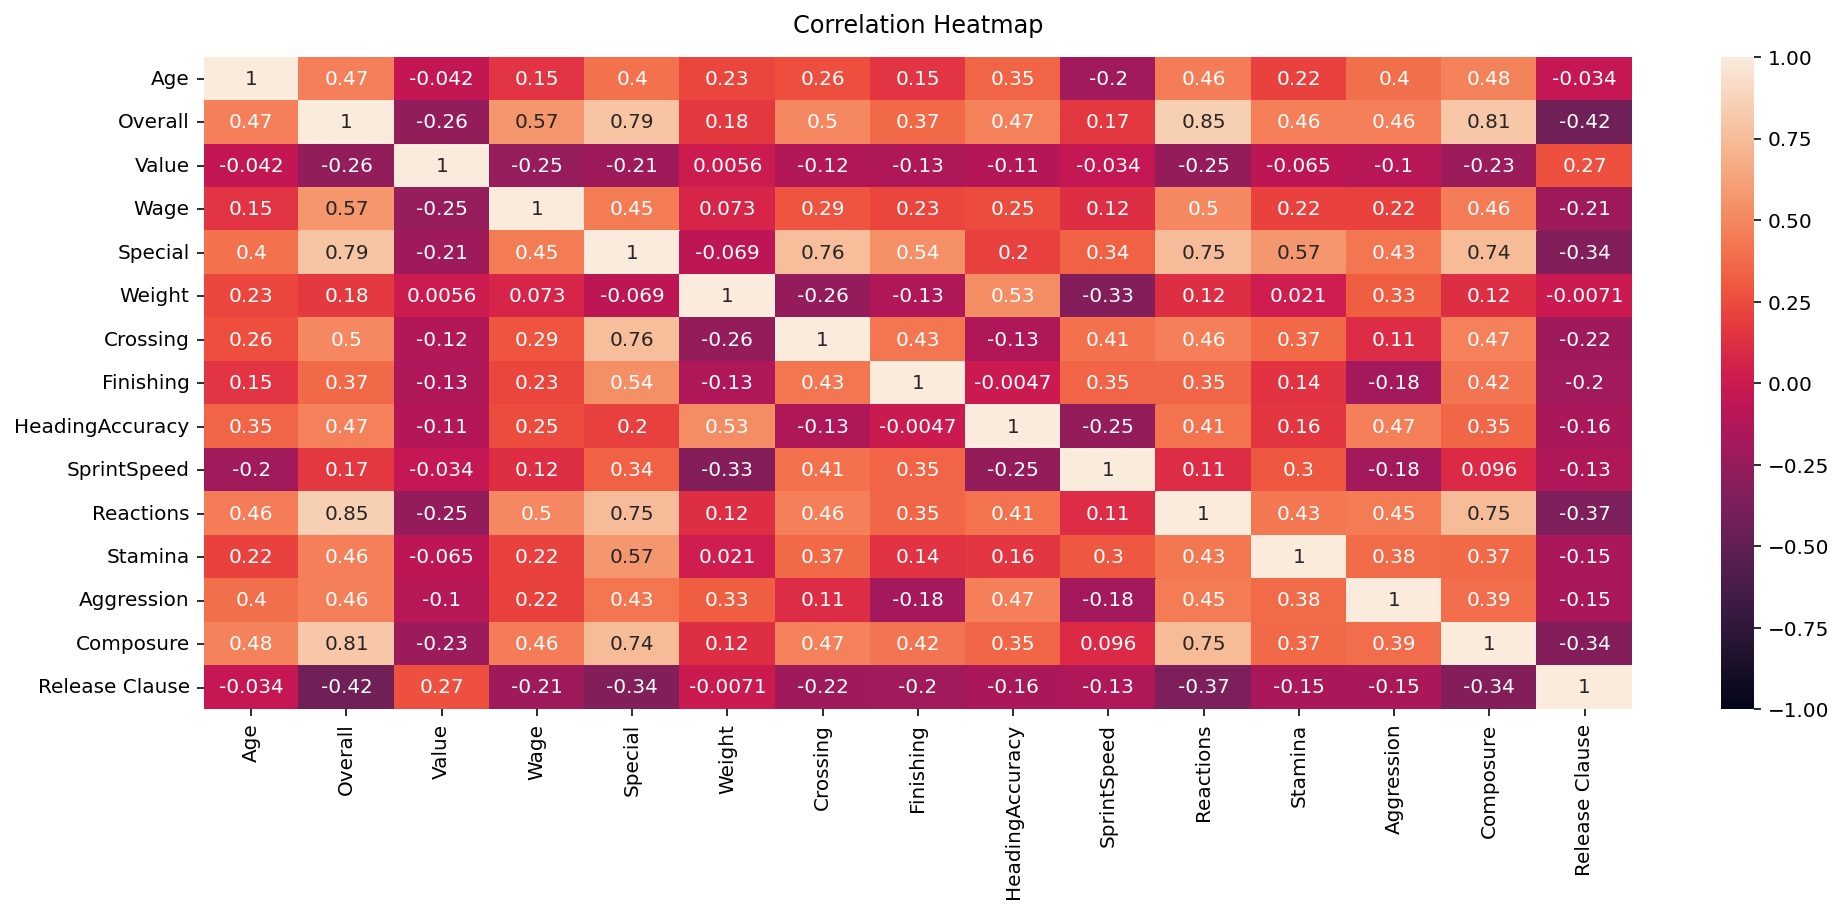

In [54]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### New XGBoost model

In [55]:
dtrain = xgb.DMatrix(
    df_train.loc[:, df_train.columns != "Overall"], label=df_train["Overall"]
)
dtest = xgb.DMatrix(
    df_test.loc[:, df_test.columns != "Overall"], label=df_test["Overall"]
)
dval = xgb.DMatrix(
    df_val.loc[:, df_val.columns != "Overall"], label=df_val["Overall"]
)

In [56]:
param = {
    "objective": "reg:squarederror",
}
num_round = 100
xgb_model = xgb.train(param, dtrain, num_round)

In [57]:
xgb_preds_test = xgb_model.predict(dtest)
print("XGB preds test model eval: ")
pprint(eval_model(df_test["Overall"], xgb_preds_test))

XGB preds test model eval: 
{'mean_absolute_error': 0.5093176367324099,
 'mean_squared_error': 0.5993926420015462,
 'pearsonr': 0.9936927813703567,
 'r2': 0.987420117649584,
 'root_mean_squared_error': 0.7742045220751078}


In [58]:
xgb_preds_val = xgb_model.predict(dval)
print("XGBpreds val model eval: ")
pprint(eval_model(df_val["Overall"], xgb_preds_val))

XGBpreds val model eval: 
{'mean_absolute_error': 0.4991898069384948,
 'mean_squared_error': 0.5158341093817237,
 'pearsonr': 0.9945785730763534,
 'r2': 0.9891671452345451,
 'root_mean_squared_error': 0.718215921141911}


### New Random Forest Regressor

In [59]:
regressor_model = RandomForestRegressor().fit(
    df_train.loc[:, df_train.columns != "Overall"], df_train["Overall"])

In [60]:
rf_preds_test = regressor_model.predict(df_test.loc[:, df_test.columns != "Overall"])
print("Random forest preds test model eval: ")
pprint(eval_model(df_test["Overall"], rf_preds_test))

Random forest preds test model eval: 
{'mean_absolute_error': 0.41604950830790094,
 'mean_squared_error': 0.5084199728721598,
 'pearsonr': 0.9946547723525214,
 'r2': 0.9893294261638318,
 'root_mean_squared_error': 0.7130357444561667}


In [61]:
rf_preds_val = regressor_model.predict(df_val.loc[:, df_val.columns != "Overall"])
print("Random forest preds val model eval: ")
pprint(eval_model(df_val["Overall"], rf_preds_val))

Random forest preds val model eval: 
{'mean_absolute_error': 0.41574092912851823,
 'mean_squared_error': 0.41269976263140057,
 'pearsonr': 0.9956607429041301,
 'r2': 0.9913330341886808,
 'root_mean_squared_error': 0.6424171251075119}


## Hyper-parameter optimization

In [62]:
# Let's look at the current parameters in use for our Random forest since it has a similar perfomance to the XG boost. 
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(regressor_model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Defining some of the params:

- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [63]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

# Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [64]:
regressor_model = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = regressor_model, param_distributions = random_grid, n_iter = 20, cv = 2, verbose=2, random_state=0, n_jobs = -1)
rf_random.fit(df_train.loc[:, df_train.columns != "Overall"], df_train["Overall"])

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 14.2min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [65]:
# Extract the best params and best estimator
best_params = rf_random.best_params_
best_model = rf_random.best_estimator_
pprint(best_params)

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 800}


In [66]:
# The random forest regressor seems to give the best perfomance hence lets see if we can get a better performance with some optimization.
rf_preds_test = best_model.predict(df_test.loc[:, df_test.columns != "Overall"])
print("Random forest preds test model eval: ")
pprint(eval_model(df_test["Overall"], rf_preds_test))

Random forest preds test model eval: 
{'mean_absolute_error': 0.4130907045720754,
 'mean_squared_error': 0.4872301007507121,
 'pearsonr': 0.9948799947938533,
 'r2': 0.9897741531751911,
 'root_mean_squared_error': 0.6980186965624289}


In [67]:
rf_preds_val = best_model.predict(df_val.loc[:, df_val.columns != "Overall"])
print("Random forest preds val model eval: ")
pprint(eval_model(df_val["Overall"], rf_preds_val))

Random forest preds val model eval: 
{'mean_absolute_error': 0.41425835454977716,
 'mean_squared_error': 0.41314768611367014,
 'pearsonr': 0.9956579184260886,
 'r2': 0.9913236275016448,
 'root_mean_squared_error': 0.6427656541179453}


With hyper-parameter optimization, we are able to go from 0.989 - 0.99 hence a 0.01 improvement in the R2 score. 

## Generate predictions with the best model

Using the model on data it did not use to train.

In [73]:
test_data_prediction = best_model.predict(df_test.loc[:, df_test.columns != "Overall"])
test_data_prediction = pd.DataFrame(test_data_prediction)
new_dataframe = test_data_prediction.copy()

In [74]:
new_dataframe["original overall"] = df_test["Overall"].values
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2949 entries, 0 to 2948
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   0                 2949 non-null   float64
 1   original overall  2949 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 46.2 KB


In [75]:
new_dataframe.columns = ["test_data_prediction", "original_overall"]
# Convert the model predictions to integers since the original predictions are
# also integers.
new_dataframe["test_data_prediction"] = new_dataframe["test_data_prediction"].astype(int)
new_dataframe.head()

,test_data_prediction,original_overall
0,61,61
1,66,65
2,58,59
3,63,64
4,76,76


Text(0.5, 1.0, 'Distribution of prediction vs actual value')

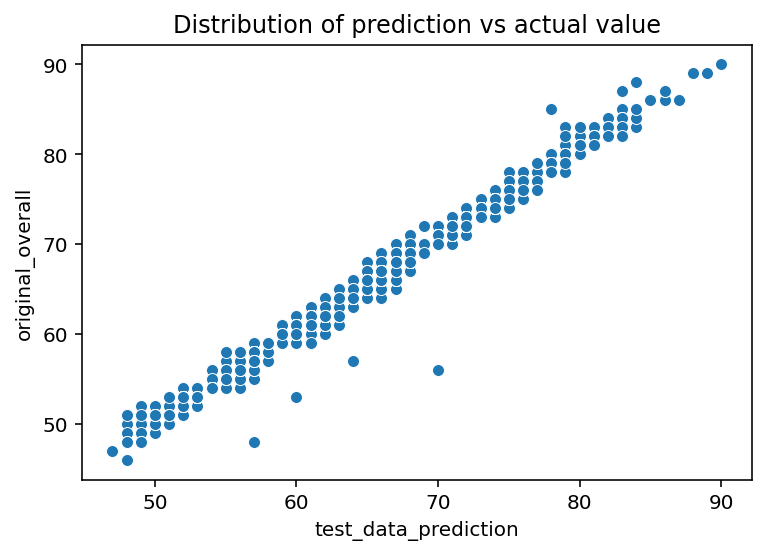

In [76]:
sns.scatterplot(x="test_data_prediction", y="original_overall", data=new_dataframe).set_title("Distribution of prediction vs actual value")

In [77]:
val_data_prediction = best_model.predict(df_val.loc[:, df_val.columns != "Overall"])
val_data_prediction = pd.DataFrame(val_data_prediction)
new_dataframe = val_data_prediction.copy()

In [78]:
new_dataframe["original overall"] = df_val["Overall"].values
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2949 entries, 0 to 2948
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   0                 2949 non-null   float64
 1   original overall  2949 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 46.2 KB


In [79]:
new_dataframe.columns = ["test_data_prediction", "original_overall"]
# Convert the model predictions to integers since the original predictions are
# also integers.
new_dataframe["test_data_prediction"] = new_dataframe["test_data_prediction"].astype(int)
new_dataframe.head()

,test_data_prediction,original_overall
0,84,84
1,48,47
2,76,76
3,75,76
4,60,60


Text(0.5, 1.0, 'Distribution of prediction vs actual value')

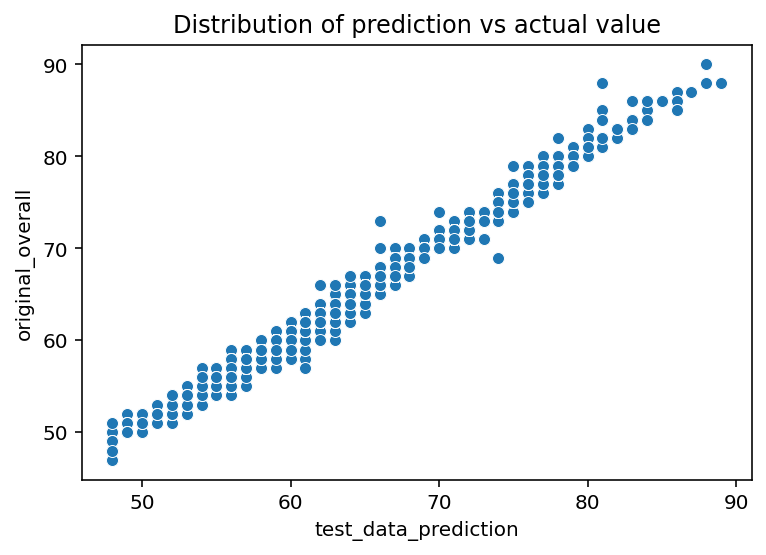

In [80]:
sns.scatterplot(x="test_data_prediction", y="original_overall", data=new_dataframe).set_title("Distribution of prediction vs actual value")

## Save model

In [81]:
import joblib

joblib.dump(best_model, "./random_forest.joblib", compress=3)

['./random_forest.joblib']

## Load Model and test

In [82]:
loaded_rf = joblib.load("./random_forest.joblib")
print("r2_score (Test data):", loaded_rf.score(df_test.loc[:, df_test.columns != "Overall"], df_test["Overall"]))

r2_score (Test data): 0.9897741531751911
